# A toy 21-cm Cosmology Emulator

We will approximate the sky-averaged 21-cm signal as a Gaussian absorption feature with three parameters: an amplitude $A$, a central redshift $z_c$, and a width $\sigma$. We will then build a simple emulator with a neural network to predict the signal temperature given a set of parameters and redshift input.

We will start by loading the relevant modules.

In [ ]:
%load_ext autoreload
#autoreload 2

import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: [METAL(id=0)]


## Generating training and test data

We need a set of example signals to train our neural network with and a set to test the accuracy of the emulator.

We are modelling the signal as a Gaussian so we need to define a function to generate gaussian signals. We will also need a function to generate a set of parameters for the signals and so need to define a prior over which to train our neural network emulator. When defining our prior we should bear in mind the prior we want to explore in our inference since outside the range of the prior the emulator will not be reliable.

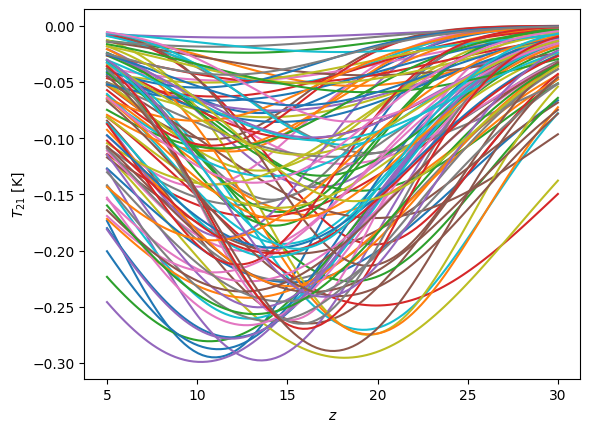

In [9]:
@jax.jit
def gaussian(params, z):
    return -params[0] * \
        jnp.exp(-0.5 * (z - params[1])**2 / params[2]**2)

def prior(n, key):
    keys = jax.random.split(key, 3)
    amp = jax.random.uniform(keys[0], (n,))* \
        (0.3 - 0.01) + 0.01
    mean = jax.random.uniform(keys[1], (n,))* \
        (20 - 10) + 10
    width = jax.random.uniform(keys[2], (n,))* \
        (10 - 5) + 5
    return jnp.stack([amp, mean, width], axis=1)

key = jax.random.PRNGKey(0)
split_key, key = jax.random.split(key)

z = jnp.linspace(5, 30, 100)[::-1]
parameters = prior(1000, split_key)

vmapped_gaussian = jax.vmap(gaussian, in_axes=(0, None))
y = vmapped_gaussian(parameters, z)

[plt.plot(z, y[i]) for i in range(100)]
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21}$ [K]')
plt.savefig('gaussian-signals.png', dpi=300, bbox_inches='tight')



Once we have generated a large sample, here 15000, of signals we need to split the signals into a training and test set. Then we need to normalise the data so that the inputs and outputs of the network are all of order one. This makes the problem easier to fit.

For our problem we also want to tile the inputs with redshift so that we can keep the network small and predict a single temperature for a single redhsift input. Our input training data for N signals and K redshifts will look something like

```
[[A1, zc1, sigma1, z1],
[A1, zc1, sigma1, z2],
[A1, zc1, sigma1, z3],
...
[A1, zc1, sigma1, zK],
[A2, zc2, sigma2, z1],
[A2, zc2, sigma2, z2],
[A2, zc2, sigma2, z3],
...
[A2, zc2, sigma2, zK],
...
[AN, zcN, sigmaN, z1],
[AN, zcN, sigmaN, z2],
[AN, zcN, sigmaN, z3],
...
[AN, zcN, sigmaN, zK]]
```

(80000, 4) (80000,)


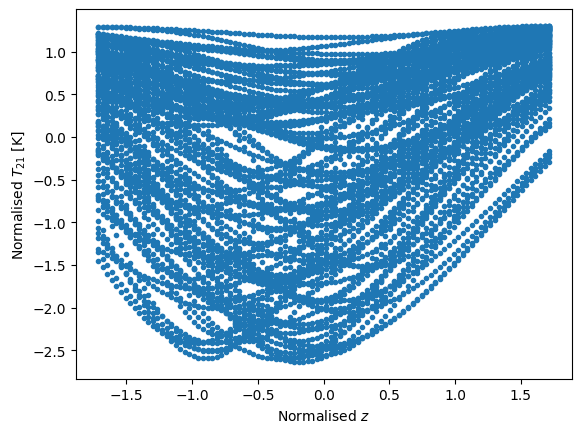

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(parameters, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

@jax.jit
def tile(params, z):
    tiled_params = jnp.tile(params, (z.shape[0], 1))
    stacked = jnp.concatenate((tiled_params, z[:, jnp.newaxis]), axis=1)
    return stacked

vmaped_tile = jax.vmap(tile, in_axes=(0, None))
X_train_tiled = vmaped_tile(X_train, z).reshape(-1, 4)
X_val_tiled = vmaped_tile(X_val, z).reshape(-1, 4)
X_test_tiled = vmaped_tile(X_test, z).reshape(-1, 4)

mean_params = jnp.mean(X_train_tiled, axis=0)
std_params = jnp.std(X_train_tiled, axis=0)
mean_signals = jnp.mean(y_train, axis=0)
std_signals = jnp.std(y_train, axis=0)


X_train_tiled = (X_train_tiled - mean_params) / std_params
X_val_tiled = (X_val_tiled - mean_params) / std_params
X_test_tiled = (X_test_tiled - mean_params) / std_params

y_train = (y_train - mean_signals) / std_signals
y_val = (y_val - mean_signals) / std_signals
y_test = (y_test - mean_signals) / std_signals

print(X_train_tiled.shape, y_train.shape)
plt.scatter(X_train_tiled[:10000, -1], y_train[:10000], marker='.')
plt.xlabel(r'Normalised $z$')
plt.ylabel(r'Normalised $T_{21}$ [K]')
plt.savefig('gaussian-normalised-signals-jax.png', dpi=300, bbox_inches='tight')

## Building the neural network and training

Now we can set up and train the neural network. We have to make some choice about the architecture of our network and the activation functions. Here we have 4 inputs (A, zc, sigma, z) and one output (T(z)) so we have a very simple network with only four hidden layers of 8 nodes each. We make the network a fully connected network and use sigmoid activation funcitons on the input layer and hidden layers. We have a linear activation function on the output node.

We use the adam optimizer (a fairly standard choice) to optimize the weights of the network connections. Adam is a stochastic gradient descent algorithm that uses moments to speed up the optimization and has an adaptive learning rate (step size to take at each iteration). We use a mean squared error loss function and run early stopping on the test data to prevent over fitting.

In [11]:
def initialise(key, inshape, outshape, nlayers, nunits):
    keys = jax.random.split(key, nlayers + 2)
    inweights = jax.random.normal(keys[0], (inshape, nunits))
    inbiases = jax.random.normal(keys[1], (nunits,))
    outweights = jax.random.normal(keys[-1], (nunits, outshape))
    outbiases = jax.random.normal(keys[-2], (outshape,))
    weights = {'weights' + str(i): jax.random.normal(k, (nunits, nunits))
           for i, k in enumerate(keys[2:-2])}
    biases = {'biases' + str(i): jax.random.normal(k, (nunits,))
            for i, k in enumerate(keys[2:-2])}
    inout = {'weights0': inweights, 'biases0': inbiases,
                'weights' + str(nlayers - 2): outweights,
                'biases' + str(nlayers - 2): outbiases}
    params = {**weights, **biases, **inout}
    return params

@jax.jit
def forward(params, X):
    for i in range(len(params) // 2):
        W = params['weights' + str(i)]
        b = params['biases' + str(i)]
        X = jnp.dot(X, W) + b
        if i < len(params) // 2 - 1:
            X = jax.nn.relu(X)
    return X

@jax.jit
def loss(params, X, y):
    y_pred = forward(params, X)
    return jnp.mean((y_pred - y)**2)



In [12]:
import optax

split_key, key = jax.random.split(key)
params = initialise(split_key, 4, 1, 5, 128)

optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

value_and_grad_loss = jax.value_and_grad(loss)

nepochs = 100
batch_size = 1000
ntrain = X_train_tiled.shape[0]
nsteps = ntrain // batch_size

for epoch in tqdm(range(nepochs)):
    split_key, key = jax.random.split(key)
    indices = jax.random.permutation(split_key, ntrain)
    for step in range(nsteps):
        batch_indices = indices[step*batch_size:(step+1)*batch_size]
        X_batch = X_train_tiled[batch_indices]
        y_batch = y_train[batch_indices]
        value, grads = value_and_grad_loss(params, X_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {value}')


  1%|          | 1/100 [00:02<04:31,  2.74s/it]

Epoch: 0, Loss: 17546.3984375


  7%|▋         | 7/100 [01:06<14:45,  9.53s/it]


KeyboardInterrupt: 